#### 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import pickle
### 전처리
# 경사도, 배수등급 '기타' 처리
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
# 스케일링
from sklearn.preprocessing import StandardScaler
### 모델링
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
# 모델들
from sklearn.neighbors import KNeighborsClassifier
import sklearn.discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
# Tree 시각화
from sklearn.tree import export_graphviz
from subprocess import check_call
from graphviz import Source
from IPython.display import Image
# 업샘플링
from sklearn.utils import resample
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
!apt-get -qq install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
pothole_original = pd.read_csv('/content/drive/MyDrive/DATA_완성/dataset.csv')
pothole = pothole_original
pothole.head(2)

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,평균_건물연령,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도
0,종로구,종로1가,126.979625,37.570080,3.0,22007.0,1728.0,2352.0,26087.0,0.156400,...,29.5,2.023010e+16,2022-12-05,72414.058824,3338.573374,64.588456,43.0,9.641935,약간불량,0-2%
1,종로구,종로1가,126.979760,37.570214,4.0,28631.0,1872.0,2959.0,33462.0,0.144373,...,29.5,2.023072e+16,2023-06-17,72414.058824,3338.573374,65.783242,45.6,8.848387,약간불량,0-2%


In [ ]:
pothole.columns

Index(['자치구', '행정동', '경도', '위도', '차선수', '승용차', '버스', '트럭', '총교통량', '중대형차량 교통량',
       '포트홀 존재여부', '평균_건물연령', '등록번호', '발생일', '인구 수', '누적 강수량', '평균 습도',
       '1년 기온차', '평균 일교차', '배수등급', '경사도'],
      dtype='object')

#### 전처리 진행

##### 배수등급, 경사도 변수 처리

In [ ]:
### 경사도
print("경사도 변수 :",pothole['경사도'].unique())
print("기타인 데이터 개수 :",len(pothole[pothole['경사도'] == '기타']))
slope_encoding = {
    '0-2%': 0,
    '2-7%': 1,
    '7-15%': 2,
    '15-30%': 3,
    '30-60%': 4,
    '60-100%': 5}

경사도 변수 : ['0-2%' '7-15%' '30-60%' '기타' '2-7%' '15-30%' '60-100%']
기타인 데이터 개수 : 2533


In [ ]:
### 배수등급
print("배수등급 변수 :",pothole['배수등급'].unique())
print("기타인 데이터 개수 :",len(pothole[pothole['배수등급'] == '기타']))
drain_encoding = {
    '매우양호': 5,
    '양호': 4,
    '약간양호': 3,
    '약간불량': 2,
    '불량': 1,
    '매우불량': 0}

배수등급 변수 : ['약간불량' '양호' '매우양호' '기타' '매우불량' '약간양호' '불량']
기타인 데이터 개수 : 2533


In [ ]:
pothole['경사도'] = pothole['경사도'].map(slope_encoding)
pothole['배수등급'] = pothole['배수등급'].map(drain_encoding)
pothole.head(2)

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,평균_건물연령,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도
0,종로구,종로1가,126.979625,37.570080,3.0,22007.0,1728.0,2352.0,26087.0,0.156400,...,29.5,2.023010e+16,2022-12-05,72414.058824,3338.573374,64.588456,43.0,9.641935,2.0,0.0
1,종로구,종로1가,126.979760,37.570214,4.0,28631.0,1872.0,2959.0,33462.0,0.144373,...,29.5,2.023072e+16,2023-06-17,72414.058824,3338.573374,65.783242,45.6,8.848387,2.0,0.0


In [ ]:
### '기타'인 데이터는 NaN으로 인코딩됨 !
pothole.isna().sum() # NaN - 2533
### 자치구도 반영하기!
gu_encoder = LabelEncoder()
pothole['자치구_enc'] = gu_encoder.fit_transform(pothole['자치구'])
### 채워넣을 데이터 분리
knn_train = pothole[pothole['배수등급'].notna()]
knn_test = pothole[pothole['배수등급'].isna()]

In [ ]:
### 모델 - 경사도
# 모델 fitting
knn_slope = KNeighborsClassifier(n_neighbors = 3)
knn_slope.fit(knn_train[['경도', '위도', '자치구_enc']], knn_train['경사도'])
# prediction
pred_slope = knn_slope.predict(knn_test[['경도', '위도', '자치구_enc']])
pothole.loc[knn_test.index, '경사도'] = pred_slope
### 모델 - 배수등급
# 모델 fitting
knn_drain = KNeighborsClassifier(n_neighbors = 3)
knn_drain.fit(knn_train[['경도', '위도', '자치구_enc']], knn_train['배수등급'])
# prediction
pred_drain = knn_drain.predict(knn_test[['경도', '위도', '자치구_enc']])
pothole.loc[knn_test.index, '배수등급'] = pred_drain

In [ ]:
pothole.head()

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도,자치구_enc
0,종로구,종로1가,126.979625,37.570080,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,...,2.023010e+16,2022-12-05,-2.223687,3.080403,0.681292,-0.683961,0.692359,2.0,0.0,22
1,종로구,종로1가,126.979760,37.570214,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023072e+16,2023-06-17,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0,22
2,종로구,종로1가,126.979760,37.570214,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023072e+16,2023-06-17,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0,22
3,종로구,종로1가,126.981416,37.570233,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023053e+16,2023-04-25,-2.223687,3.080403,0.727170,0.992087,1.363963,2.0,0.0,22
4,종로구,종로1가,126.981416,37.570233,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023053e+16,2023-04-25,-2.223687,3.080403,0.727170,0.992087,1.363963,2.0,0.0,22


In [ ]:
pothole.isna().sum()

,0
자치구,0
행정동,0
경도,0
위도,0
차선수,0
승용차,0
버스,0
트럭,0
총교통량,0
중대형차량 교통량,0


In [ ]:
pothole.to_pickle('/content/drive/MyDrive/DATA_완성/dataset_road_knn.pickle')

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도,자치구_enc
0,종로구,종로1가,126.979625,37.570080,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,...,2.023010e+16,2022-12-05,-2.223687,3.080403,0.681292,-0.683961,0.692359,2.0,0.0,22
1,종로구,종로1가,126.979760,37.570214,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023072e+16,2023-06-17,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0,22
2,종로구,종로1가,126.979760,37.570214,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023072e+16,2023-06-17,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0,22
3,종로구,종로1가,126.981416,37.570233,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023053e+16,2023-04-25,-2.223687,3.080403,0.727170,0.992087,1.363963,2.0,0.0,22
4,종로구,종로1가,126.981416,37.570233,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023053e+16,2023-04-25,-2.223687,3.080403,0.727170,0.992087,1.363963,2.0,0.0,22


##### Scaling

In [ ]:
scaling_vars = ['승용차', '버스', '트럭', '총교통량', '중대형차량 교통량', '평균_건물연령',
                '누적 강수량', '평균 습도', '1년 기온차', '평균 일교차']

In [ ]:
scaler = StandardScaler()
pothole[scaling_vars] = scaler.fit_transform(pothole[scaling_vars])
pothole.head(2)

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도,자치구_enc
0,종로구,종로1가,126.979625,37.570080,3.0,-0.108116,1.294472,-0.151648,-0.069729,0.590006,...,2.023010e+16,2022-12-05,72414.058824,5.584335,0.556378,-0.539800,0.551451,2.0,0.0,22
1,종로구,종로1가,126.979760,37.570214,4.0,0.270749,1.513561,0.117050,0.302368,0.278842,...,2.023072e+16,2023-06-17,72414.058824,5.584335,0.862972,0.944278,-0.019248,2.0,0.0,22


#### 데이터 불러오기~

In [ ]:
pothole = pd.read_pickle('/content/drive/MyDrive/DATA_완성/dataset_knn.pickle')

### x, y 할당

 - x : 자치구/행정동/경도/위도/등록번호/발생일 - 삭제
 - y : 포트홀 존재 여부

In [ ]:
### x, y 할당
x = pothole.drop(['자치구', '행정동', '경도', '위도', '등록번호', '발생일', '포트홀 존재여부', '자치구_enc'], axis=1)
y = pothole['포트홀 존재여부']
x.head(2)

,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,평균_건물연령,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도
0,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,-0.581126,-2.223687,3.080403,0.681292,-0.683961,0.692359,2.0,0.0
1,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,-0.581126,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0


In [ ]:
x2 = x.drop(['누적 강수량', '평균 습도', '1년 기온차', '평균 일교차'], axis = 1)
x2.head(2)

,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,평균_건물연령,인구 수,배수등급,경사도
0,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,-0.581126,-2.223687,2.0,0.0
1,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,-0.581126,-2.223687,2.0,0.0


In [ ]:
### train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 1384)

### Original Data

#### KNN

In [ ]:
####### KNN ##########################
### fitting
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(x_train, y_train)
### prediction
knn_pred = knn_model.predict(x_test)
knn_pred_prob = knn_model.predict_proba(x_test)[:,1]
### accuracy
knn_acc = accuracy_score(y_test, knn_pred)
knn_auc = roc_auc_score(y_test, knn_pred_prob)
print("KNN - Accuracy : {:.4f}". format(knn_acc))
print("KNN - AUC : {:.4f}". format(knn_roc))

KNN - Accuracy : 0.9866
KNN - AUC : 0.9964


#### LDA/QDA

- LDA

In [ ]:
####### LDA ##########################
### fitting
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train, y_train)
### prediction
lda_pred = lda_model.predict(x_test)
lda_pred_prob = lda_model.predict_proba(x_test)[:,1]
### accuracy
lda_acc = accuracy_score(y_test, lda_pred)
lda_auc = roc_auc_score(y_test, lda_pred_prob)
print("LDA - Accuracy : {:.4f}". format(lda_acc))
print("LDA - AUC : {:.4f}". format(lda_auc))

LDA - Accuracy : 0.9481
LDA - AUC : 0.9707


- QDA

In [ ]:
####### QDA ##########################
### fitting
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(x_train, y_train)
### prediction
qda_pred = qda_model.predict(x_test)
qda_pred_prob = qda_model.predict_proba(x_test)[:,1]
### accuracy
qda_acc = accuracy_score(y_test, qda_pred)
qda_auc = roc_auc_score(y_test, qda_pred_prob)
print("QDA - Accuracy : {:.4f}". format(qda_acc))
print("QDA - AUC : {:.4f}". format(qda_auc))

QDA - Accuracy : 0.9637
QDA - AUC : 0.9933


#### Tree

In [ ]:
### Hyperparameter - 일단은 train 기준으로만
depths = {'max_depth' : [5, 7, 10, 15]}
tree_cv = GridSearchCV(DecisionTreeClassifier(), param_grid = depths, cv = 5)
tree_cv.fit(x_train, y_train)

print('GridSearch 최고 평균 정확도 : {:.4f}'. format(tree_cv.best_score_))
print('GridSearch 최적 파라미터 : ', tree_cv.best_params_)

GridSearch 최고 평균 정확도 : 0.9980
GridSearch 최적 파라미터 :  {'max_depth': 7}


In [ ]:
####### Tree ##########################
### fitting
tree_model = DecisionTreeClassifier(max_depth = 5)
tree_model.fit(x_train, y_train)
### prediction
tree_pred = tree_model.predict(x_test)
tree_pred_prob = tree_model.predict_proba(x_test)[:,1]
### accuracy
tree_acc = accuracy_score(y_test, tree_pred)
tree_auc = roc_auc_score(y_test, tree_pred_prob)
print("Tree - Accuracy : {:.4f}". format(tree_acc))
print("Tree - AUC : {:.4f}".format(tree_auc))

Tree - Accuracy : 0.9917
Tree - AUC : 0.9983


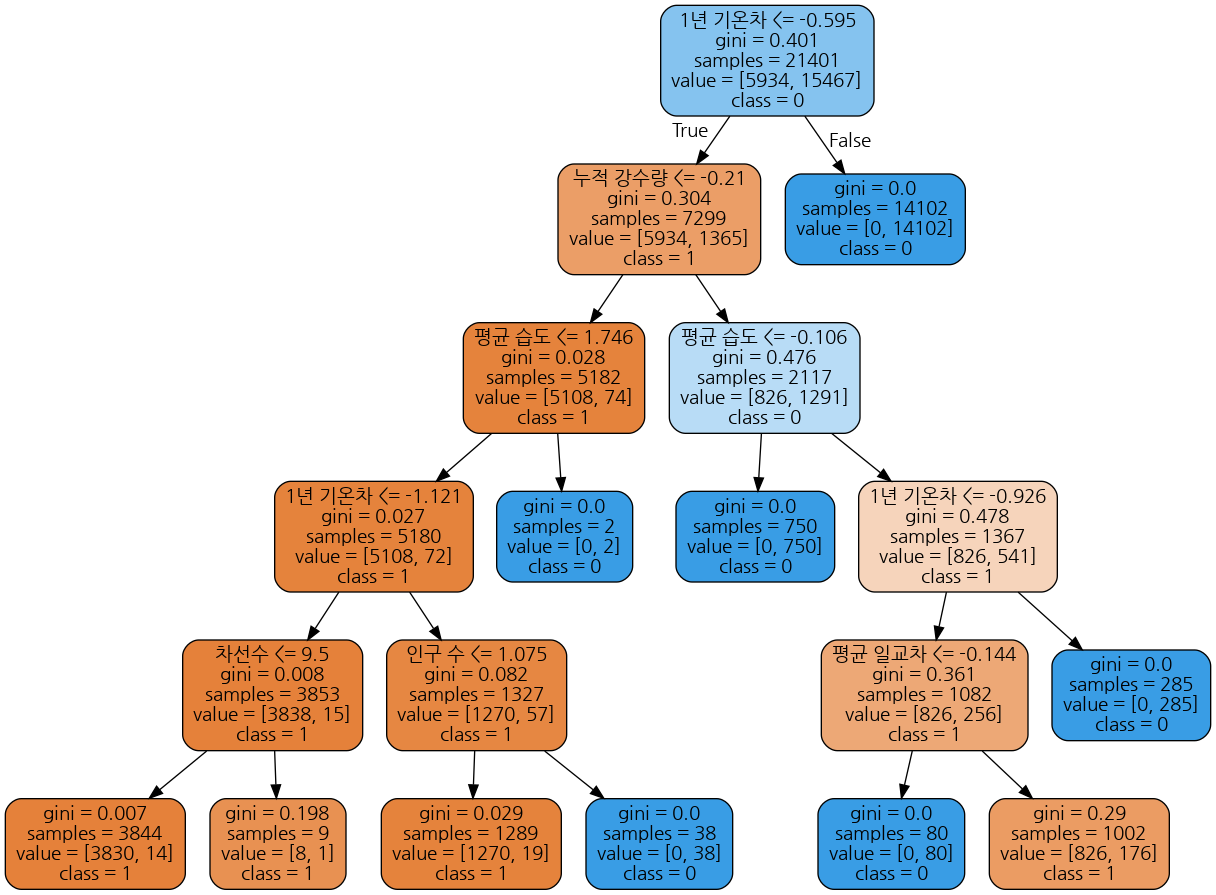

In [ ]:
tree_model_dot = export_graphviz(tree_model,
                                 out_file = None,
                                 class_names = [str(cls) for cls in y_train.unique()],
                                feature_names = x_train.columns,
                                 rounded = True, filled = True, fontname="NanumGothic")
graph = Source(tree_model_dot)
graph.render("tree_model", format = "png")
Image(filename = "tree_model.png")

### Up-Sampling

In [ ]:
pothole['포트홀 존재여부'].value_counts()

,count
포트홀 존재여부,
1,22096
0,8478


- 찾아보니 train에만 업샘플링하는 게 맞다고 해서.. 일단은 그렇게 진행

In [ ]:
y_train

,포트홀 존재여부
17731,1
782,1
22489,0
19184,1
418,1
...,...
26798,0
3260,1
18268,1
26599,0


In [ ]:
### 기존 train
train = pd.concat([x_train, y_train], axis = 1)
train_major = train[y_train == 1]
train_minor = train[y_train == 0]
### 업샘플링 진행
train_minor_upsampled = resample(train_minor, replace = True, n_samples = len(train_major), random_state = 1384)
train_upsampled = pd.concat([train_major, train_minor_upsampled]).sample(frac = 1, random_state = 1384)
x_train_up = train_upsampled.drop('포트홀 존재여부', axis = 1)
y_train_up = train_upsampled['포트홀 존재여부']

#### KNN

In [ ]:
####### KNN ##########################
### fitting
knn_model_up = KNeighborsClassifier(n_neighbors = 3)
knn_model_up.fit(x_train_up, y_train_up)
### prediction
knn_pred_up = knn_model_up.predict(x_test)
knn_pred_prob_up = knn_model_up.predict_proba(x_test)[:,1]
### accuracy
knn_acc_up = accuracy_score(y_test, knn_pred_up)
knn_roc_up = roc_auc_score(y_test, knn_pred_prob_up)
print("KNN_up - Accuracy : {:.4f}". format(knn_acc_up))
print("KNN_up - AUC : {:.4f}". format(knn_roc_up))

KNN_up - Accuracy : 0.9848
KNN_up - AUC : 0.9941


#### LDA/QDA

In [ ]:
####### LDA ##########################
### fitting
lda_model_up = LinearDiscriminantAnalysis()
lda_model_up.fit(x_train_up, y_train_up)
### prediction
lda_pred_up = lda_model_up.predict(x_test)
lda_pred_prob_up = lda_model_up.predict_proba(x_test)[:,1]
### accuracy
lda_acc_up = accuracy_score(y_test, lda_pred_up)
lda_roc_up = roc_auc_score(y_test, lda_pred_prob_up)
print("LDA_up - Accuracy : {:.4f}". format(lda_acc_up))
print("LDA_up - AUC : {:.4f}". format(lda_roc_up))

LDA_up - Accuracy : 0.9284
LDA_up - AUC : 0.9671


In [ ]:
####### QDA ##########################
### fitting
qda_model_up = QuadraticDiscriminantAnalysis()
qda_model_up.fit(x_train_up, y_train_up)
### prediction
qda_pred_up = qda_model_up.predict(x_test)
qda_pred_prob_up = qda_model_up.predict_proba(x_test)[:,1]
### accuracy
qda_acc_up = accuracy_score(y_test, qda_pred_up)
qda_roc_up = roc_auc_score(y_test, qda_pred_prob_up)
print("QDA_up - Accuracy : {:.4f}". format(qda_acc_up))
print("QDA_up - AUC : {:.4f}". format(qda_roc_up))

QDA_up - Accuracy : 0.9620
QDA_up - AUC : 0.9930


#### Tree

In [ ]:
### Hyperparameter - 일단은 train 기준으로만
depths = {'max_depth' : [5, 7, 10, 15]}
tree_cv_up = GridSearchCV(DecisionTreeClassifier(), param_grid = depths, cv = 5)
tree_cv_up.fit(x_train_up, y_train_up)

print('GridSearch_up 최고 평균 정확도 : {:.4f}'. format(tree_cv_up.best_score_))
print('GridSearch_up 최적 파라미터 : ', tree_cv_up.best_params_)

GridSearch_up 최고 평균 정확도 : 0.8703
GridSearch_up 최적 파라미터 :  {'max_depth': 15}


In [ ]:
####### Tree ##########################
### fitting
tree_model_up = DecisionTreeClassifier(max_depth = 15)
tree_model_up.fit(x_train_up, y_train_up)
### prediction
tree_pred_up = tree_model_up.predict(x_test)
tree_pred_prob_up = tree_model_up.predict_proba(x_test)[:,1]
### accuracy
tree_acc_up = accuracy_score(y_test, tree_pred_up)
tree_roc_up = roc_auc_score(y_test, tree_pred_prob_up)
print("Tree_up - Accuracy : {:.4f}". format(tree_acc_up))
print("Tree_up - AUC : {:.4f}".format(tree_roc_up))

Tree_up - Accuracy : 0.8480
Tree_up - AUC : 0.8241


In [ ]:
### FNR, Precision, F1 Score
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score

confusion = confusion_matrix(y_test, tree_pred_up)
tn, fp, fn, tp = confusion.ravel()
fnr = fn / (fn + tp)
precision = precision_score(y_test, tree_pred_up)
f1 = f1_score(y_test, tree_pred_up)

print(f"Tree_up - FNR       : {fnr:.4f}")
print(f"Tree_up - Precision : {precision:.4f}")
print(f"Tree_up - F1 score  : {f1:.4f}")

Tree_up - FNR       : 0.0017
Tree_up - Precision : 0.9982
Tree_up - F1 score  : 0.9983


In [ ]:
tree_model_dot = export_graphviz(tree_model_up,
                                 out_file = None,
                                 class_names = [str(cls) for cls in x_train_up.unique()],
                                 feature_names = x_train_up.columns,
                                 rounded = True, filled = True, fontname="NanumGothic")
graph = Source(tree_model_dot)
graph.render("tree_model", format = "png")
Image(filename = "tree_model.png")

AttributeError: 'DataFrame' object has no attribute 'unique'

### 결과

In [ ]:
print(
    "KNN Accuracy: {:.4f}".format(knn_acc),
    "LDA Accuracy: {:.4f}".format(lda_acc),
    "QDA Accuracy: {:.4f}".format(qda_acc),
    "Tree Accuracy: {:.4f}".format(tree_acc),
    "----------------------",
    "KNN_up Accuracy: {:.4f}".format(knn_acc_up),
    "LDA_up Accuracy: {:.4f}".format(lda_acc_up),
    "QDA_up Accuracy: {:.4f}".format(qda_acc_up),
    "Tree_up Accuracy: {:.4f}".format(tree_acc_up),
    sep = "\n"
)

print("-------------------------------")
print("-------------------------------")

print(
    "KNN AUC: {:.4f}".format(knn_auc),
    "LDA AUC: {:.4f}".format(lda_auc),
    "QDA AUC: {:.4f}".format(qda_auc),
    "Tree AUC: {:.4f}".format(tree_auc),
    "----------------------",
    "KNN_up AUC: {:.4f}".format(knn_roc_up),
    "LDA_up AUC: {:.4f}".format(lda_roc_up),
    "QDA_up AUC: {:.4f}".format(qda_roc_up),
    "Tree_up AUC: {:.4f}".format(tree_roc_up),
    sep = "\n"
)

KNN Accuracy: 0.9866
LDA Accuracy: 0.9481
QDA Accuracy: 0.9637
Tree Accuracy: 0.9917
----------------------
KNN_up Accuracy: 0.9848
LDA_up Accuracy: 0.9284
QDA_up Accuracy: 0.9620
Tree_up Accuracy: 0.9973
-------------------------------
-------------------------------
KNN AUC: 0.9964
LDA AUC: 0.9707
QDA AUC: 0.9933
Tree AUC: 0.9983
----------------------
KNN_up AUC: 0.9941
LDA_up AUC: 0.9671
QDA_up AUC: 0.9930
Tree_up AUC: 0.9966


In [ ]:
Models = ['KNN', 'LDA', 'QDA', 'Tree', 'KNN_up', 'LDA_up', 'QDA_up', 'Tree_up']
Accuracy = [knn_acc, lda_acc, qda_acc, tree_acc, knn_acc_up, lda_acc_up, qda_acc_up, tree_acc_up]
AUC = [knn_auc, lda_auc, qda_auc, tree_auc, knn_roc_up, lda_roc_up, qda_roc_up, tree_roc_up]
acc_max = np.argmax(Accuracy)
print(f"Best Model based on Accuracy : {Models[acc_max]}")
auc_max = np.argmax(AUC)
print(f"Best Model based on AUC : {Models[auc_max]}")

Best Model based on Accuracy : Tree_up
Best Model based on AUC : Tree


### 중복된 데이터 제거하고

In [ ]:
pothole = pd.read_pickle('/content/drive/MyDrive/DATA_완성/dataset_knn.pickle')
pothole.head(2)

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도,자치구_enc
0,종로구,종로1가,126.979625,37.570080,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,...,2.023010e+16,2022-12-05,-2.223687,3.080403,0.681292,-0.683961,0.692359,2.0,0.0,22
1,종로구,종로1가,126.979760,37.570214,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023072e+16,2023-06-17,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0,22


In [ ]:
pothole.columns

Index(['자치구', '행정동', '경도', '위도', '차선수', '승용차', '버스', '트럭', '총교통량', '중대형차량 교통량',
       '포트홀 존재여부', '평균_건물연령', '등록번호', '발생일', '인구 수', '누적 강수량', '평균 습도',
       '1년 기온차', '평균 일교차', '배수등급', '경사도', '자치구_enc'],
      dtype='object')

In [ ]:
pothole.head(2)

,자치구,행정동,경도,위도,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,...,등록번호,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도,자치구_enc
0,종로구,종로1가,126.979625,37.570080,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,...,2.023010e+16,2022-12-05,-2.223687,3.080403,0.681292,-0.683961,0.692359,2.0,0.0,22
1,종로구,종로1가,126.979760,37.570214,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,...,2.023072e+16,2023-06-17,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0,22


In [ ]:
pothole_uniq = pothole.drop(['자치구', '행정동', '경도', '위도', '등록번호', '자치구_enc'], axis=1)
len(pothole_uniq)

30574

In [ ]:
pothole_uniq.head(2)

,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,포트홀 존재여부,평균_건물연령,발생일,인구 수,누적 강수량,평균 습도,1년 기온차,평균 일교차,배수등급,경사도
0,3.0,0.158441,1.284569,0.160536,0.206347,0.686938,1,-0.581126,2022-12-05,-2.223687,3.080403,0.681292,-0.683961,0.692359,2.0,0.0
1,4.0,0.579167,1.416807,0.494772,0.609744,0.394627,1,-0.581126,2023-06-17,-2.223687,3.080403,0.936602,0.992087,0.139252,2.0,0.0


In [ ]:
pothole_uniq.columns

Index(['차선수', '승용차', '버스', '트럭', '총교통량', '중대형차량 교통량', '포트홀 존재여부', '평균_건물연령',
       '발생일', '인구 수', '누적 강수량', '평균 습도', '1년 기온차', '평균 일교차', '배수등급', '경사도'],
      dtype='object')